# Project 4: Heart Disease and Time Series Analysis

### Notebook Goals
The goal of this notebook is to create a models to predict the trend in the rate of heart disease across demographic groups and geographic regions based on 'All heart disease' subsetted from our cleaned dataset. From there we aim to use modeling approaches to predict how the variation in the dataset will deviate from the expected trend overtime. Both of these modeling ideas incorporate Time Series Analysis (TSA) since there is a time component and we are trying to predict the trend of our data overtime.




We accomplished these goals by doing Polynomial Regression, which is similar to Linear Regression, but fits a a curved line (in our case a cubic polynomial) to the data as a way to predict the trend. The next step was calculating the residuals (i.e., the difference between the Original data and the predictions from the Polynomial Regression). We took these residuals and used standard TSA models (Autoregressive and Moving Average) to see if we could predict how the variation will deviate overtime.



The demographic groups of interest to us were Sex, Minority Racial Groups (Non-White), and the Geographic Regions with the highest rates of heart disease (Southeast and Southwest).


With each demographic subgroup we go through these steps of: Polynomial Regression to Residuals to TSA Modeling with the Residuals.

#### Loading our libraries, mounting our drive, loading our data, and subsetting our data into 'All heart disease'

In [ ]:
import pandas as pd
import random as rd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels import tsa

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/project4_heart_disease/cleaned_heart_disease.csv')

In [ ]:
heart_df = df[df['disease']=='All heart disease']

In [ ]:
heart_df.head()

,Unnamed: 0,year,state,county,disease,data_value,data_value_unit,data_value_type,confidence_limit_low,confidence_limit_high,age_group,race,sex,rate_disease,region
3,108,2017,AL,Autauga,All heart disease,128.7,"per 100,000","Age-Standardized, Spatiotemporally Smoothed Rate",113.1,144.7,Adult,Overall,Overall,0.1287,Southeast
4,109,2016,AL,Autauga,All heart disease,128.1,"per 100,000","Age-Standardized, Spatiotemporally Smoothed Rate",114.1,145.5,Adult,Overall,Overall,0.1281,Southeast
5,110,2019,AL,Autauga,All heart disease,122.6,"per 100,000","Age-Standardized, Spatiotemporally Smoothed Rate",106.4,143.4,Adult,Overall,Overall,0.1226,Southeast
6,111,2006,AL,Autauga,All heart disease,164.0,"per 100,000","Age-Standardized, Spatiotemporally Smoothed Rate",142.5,194.0,Adult,Overall,Overall,0.1640,Southeast
7,112,2003,AL,Autauga,All heart disease,159.6,"per 100,000","Age-Standardized, Spatiotemporally Smoothed Rate",137.4,189.5,Adult,Overall,Overall,0.1596,Southeast


In [ ]:
heart_df.shape

(621744, 15)

In [ ]:
heart_df = heart_df.drop(columns=['Unnamed: 0', 'data_value', 'data_value_unit', 'data_value_type', 'confidence_limit_low','confidence_limit_high'])

In [ ]:
heart_df.head()

,year,state,county,disease,age_group,race,sex,rate_disease,region
3,2017,AL,Autauga,All heart disease,Adult,Overall,Overall,0.1287,Southeast
4,2016,AL,Autauga,All heart disease,Adult,Overall,Overall,0.1281,Southeast
5,2019,AL,Autauga,All heart disease,Adult,Overall,Overall,0.1226,Southeast
6,2006,AL,Autauga,All heart disease,Adult,Overall,Overall,0.1640,Southeast
7,2003,AL,Autauga,All heart disease,Adult,Overall,Overall,0.1596,Southeast


In [ ]:
def polyfit_r2(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    #calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = ssreg / sstot

    return results


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## Sex
*   Polynomial Regression
*   Residuals
*   Autoregressive and Moving Average Models

In [ ]:
heart_df['sex'].unique()

array(['Overall', 'Women', 'Men'], dtype=object)

### Females

#### Trend of Original Data
Group-by year and calculate the average rate of heart disease



Text(0.5, 1.0, 'Female')

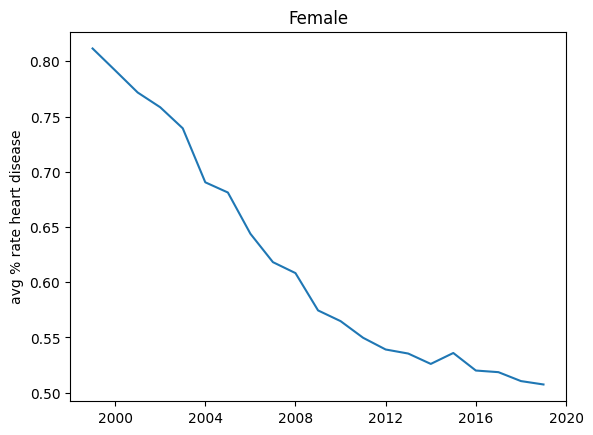

In [ ]:
female_df = heart_df[heart_df['sex']=='Women']
avg_female_df = female_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_female_df['avg_rate_disease'] = avg_female_df['rate_disease']
avg_female_df = avg_female_df.drop(columns=['rate_disease'])
plt.plot(pd.to_datetime(avg_female_df['year'], format="%Y"), avg_female_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Female')

#### Polynomial Regression
We used a cubic polynomial regression because the general trend we observed in every subgroup was a stretched out sidewards 'S' shape, which is similar to a cubic polynomial.


Here we are plotting the original data (blue and orange) and the predictions based on the polynomial regression (green).

Text(0.5, 1.0, 'Female')

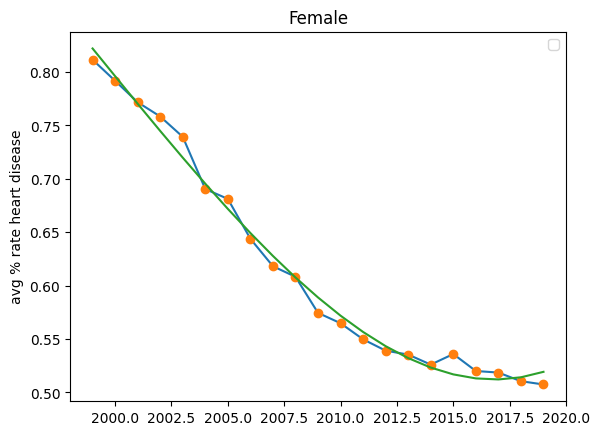

In [ ]:
# Create x and y vectors based on year and the grouped average rate of heart disease by year
x = avg_female_df['year']
y = avg_female_df['avg_rate_disease']

# Creates a Cubic Polynomial based on our data
z = np.polyfit(x, y, 3)
# Creating our Polynomial Regression Model called 'f'
f = np.poly1d(z)

# Creating the Line
x_new = np.linspace(1999, 2019, 21)
# Creating our predictions based on our model
y_new = f(x_new)

# Plotting the data
plt.plot(x, y)
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.legend()
plt.title('Female')

#### Calculating the R-squared value (how well the polynomial regression predictions fits the original data)

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.9913332955099775}

#### Plotting the Residuals

Text(0, 0.5, 'residual')

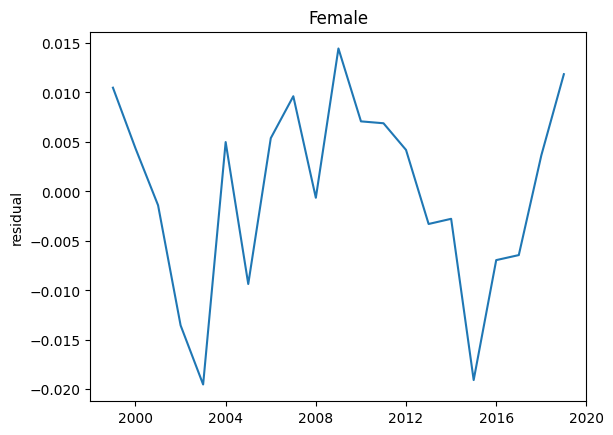

In [ ]:
# Calculating the Residuals
avg_female_df['residual'] = y_new - avg_female_df['avg_rate_disease']
avg_female_df.head()

# Plotting the Residuals
plt.plot(pd.to_datetime(avg_female_df['year'], format="%Y"), avg_female_df['residual'])
plt.title('Female')
plt.ylabel('residual')

#### Setting up the Data for TSA & Autoregressive and Moving Average Modeling

In [ ]:
# Setting the Residuals to be set up in Time Series Analysis
female_residual = avg_female_df[['year','residual']].set_index('year')
female_residual.index = pd.to_datetime(female_residual.index,format='%Y')

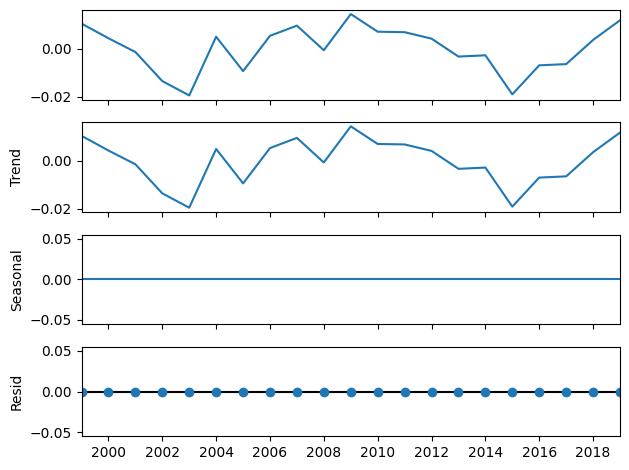

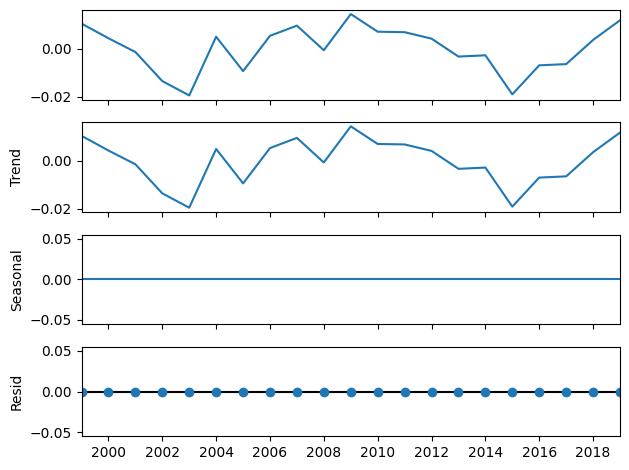

In [ ]:
# Plotting to see if there is trend and seasonality in the data
result = seasonal_decompose(female_residual)
result.plot()

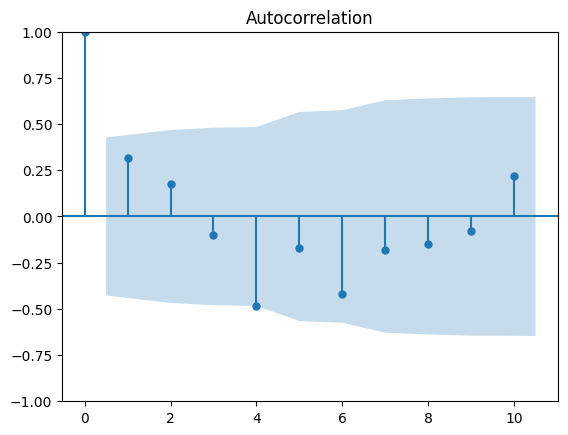

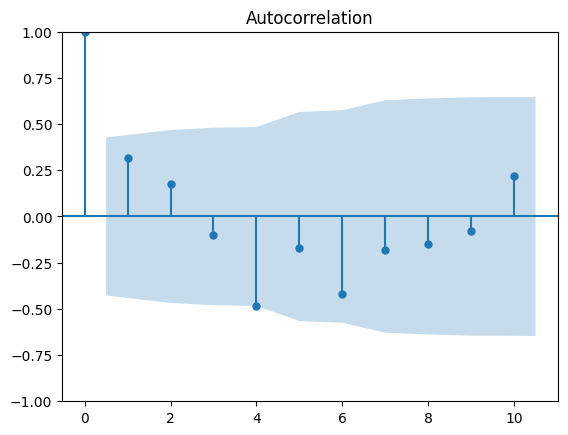

In [ ]:
# See how many lags we should use in our Autoregressive model
plot_acf(female_residual)

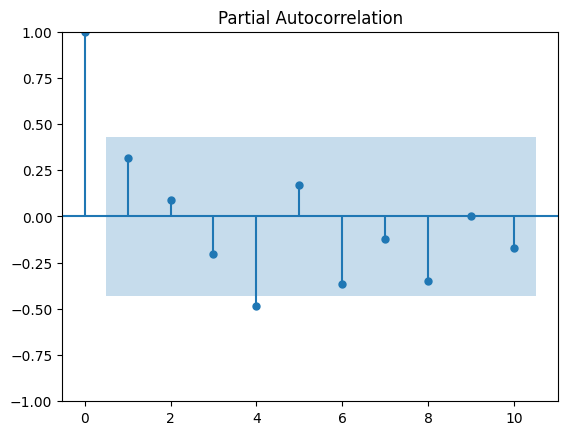

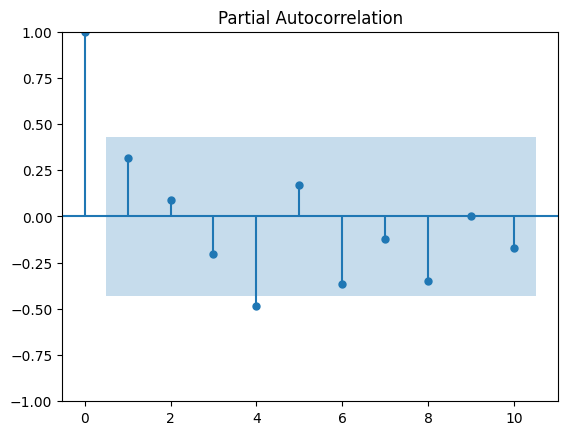

In [ ]:
# See how many lags we should use in our Moving Average Model
plot_pacf(female_residual)

##### We used AR/MA Models separately both with a lag order of 1 because our ACF/PACF were telling us to use a lag order of 0, and that would tell us nothing.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


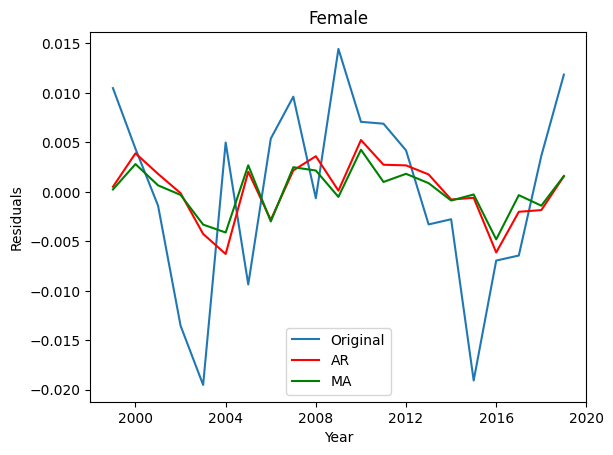

In [ ]:
# Creating and Fitting our Autoregressive Model
model = ARIMA(female_residual, order=(1, 0, 0), freq=female_residual.index.inferred_freq)
results_AR = model.fit()

# Creating and Fitting our Moving Average Model
model2 = ARIMA(female_residual, order=(0, 0, 1), freq=female_residual.index.inferred_freq)
results_MA = model2.fit()

# Plotting the Original Residuals and the predicted residuals based on the AR and MA models
plt.plot(female_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Female')
plt.show()

In [ ]:
# Print the results of the Autoregressive Model
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  69.299
Date:                Fri, 03 May 2024   AIC                           -132.597
Time:                        22:22:55   BIC                           -129.464
Sample:                    01-01-1999   HQIC                          -131.917
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.152      0.879      -0.006       0.007
ar.L1          0.3392      0.261      1.299      0.194      -0.173       0.851
sigma2      7.912e-05   3.21e-05      2.464      0.0

In [ ]:
# Print the results of the Moving Average Model
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  68.987
Date:                Fri, 03 May 2024   AIC                           -131.974
Time:                        22:22:55   BIC                           -128.841
Sample:                    01-01-1999   HQIC                          -131.294
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.003      0.088      0.930      -0.005       0.006
ma.L1          0.2685      0.246      1.091      0.275      -0.214       0.751
sigma2      8.168e-05   3.33e-05      2.453      0.0

### Males

Text(0.5, 1.0, 'Male')

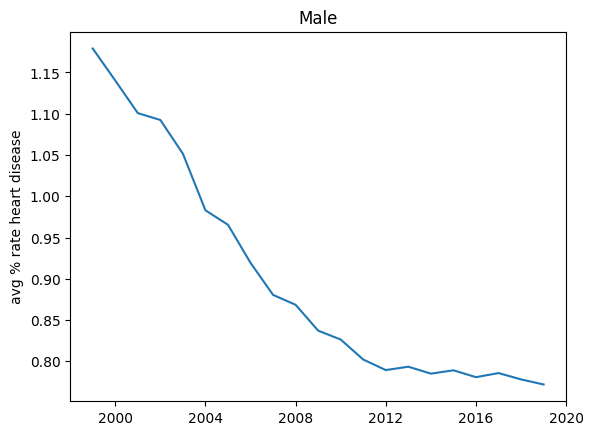

In [ ]:
male_df = heart_df[heart_df['sex']=='Men']
avg_male_df = male_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_male_df['avg_rate_disease'] = avg_male_df['rate_disease']
avg_male_df = avg_male_df.drop(columns=['rate_disease'])
plt.plot(pd.to_datetime(avg_male_df['year'], format="%Y"), avg_male_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Male')

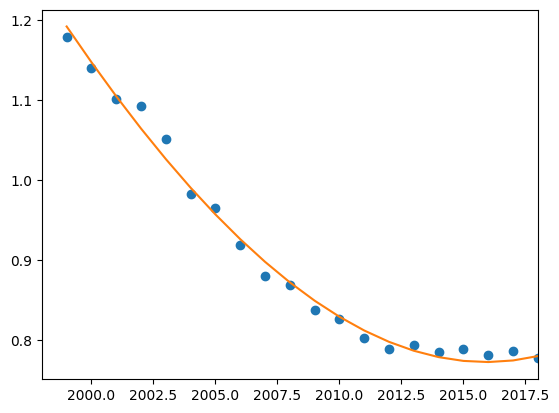

Text(0.5, 1.0, 'Male')

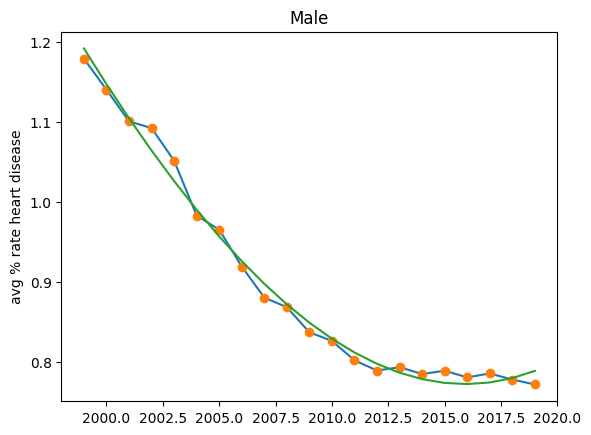

In [ ]:
# get x and y vectors
x = avg_male_df['year']
y = avg_male_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)

plt.plot(x,y,'o', x_new, y_new)
plt.xlim(1998, 2018)
plt.show()
plt.plot(avg_male_df['year'], avg_male_df['avg_rate_disease'])
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('Male')

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.9912868401658373}

Text(0.5, 1.0, 'Male')

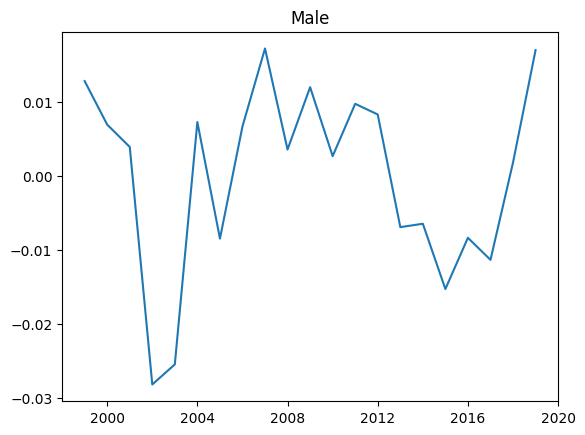

In [ ]:
avg_male_df['residual'] = y_new - avg_male_df['avg_rate_disease']
avg_male_df.head()
plt.plot(pd.to_datetime(avg_male_df['year'], format="%Y"), avg_male_df['residual'])
plt.title("Male")


In [ ]:
male_residual = avg_male_df[['year','residual']].set_index('year')
male_residual.index = pd.to_datetime(male_residual.index,format='%Y')

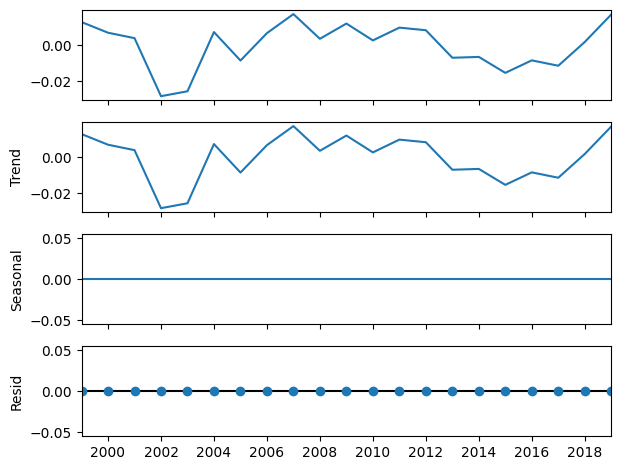

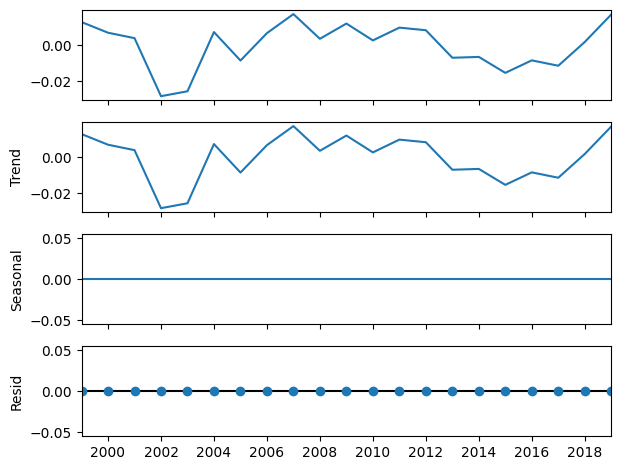

In [ ]:
result = seasonal_decompose(male_residual)
result.plot()

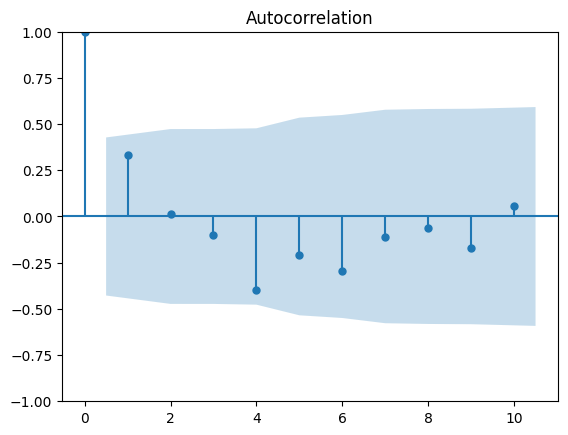

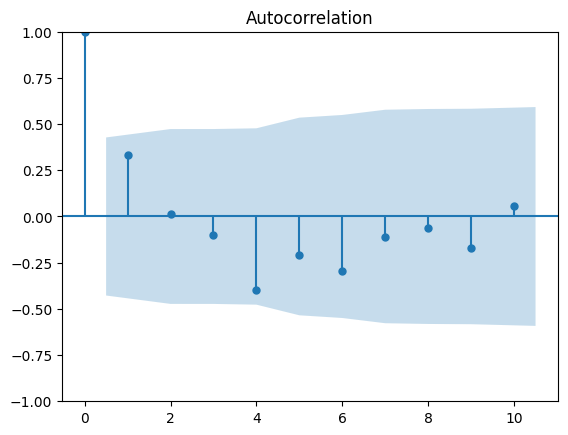

In [ ]:
plot_acf(male_residual)

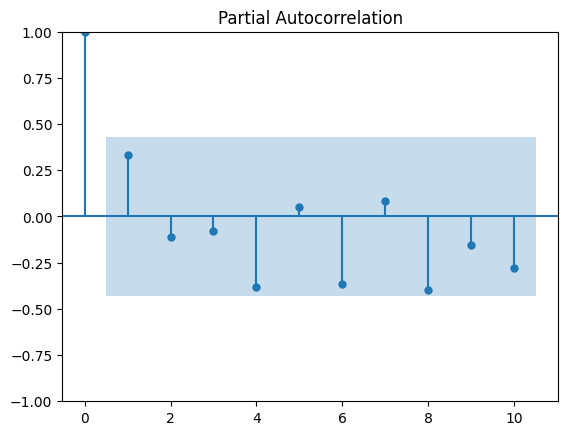

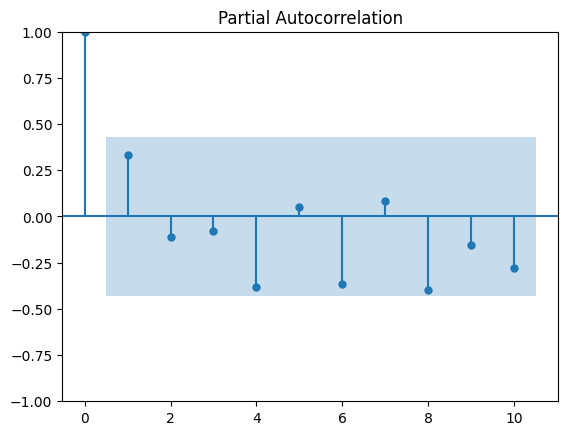

In [ ]:
plot_pacf(male_residual)

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(male_residual.residual.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -1.7871440859323338
ADF p-values: 0.38686271817258294
ADF number of lags used: 8
ADF number of observations: 12
ADF critical values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF best information criterion: -79.50091218968527


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


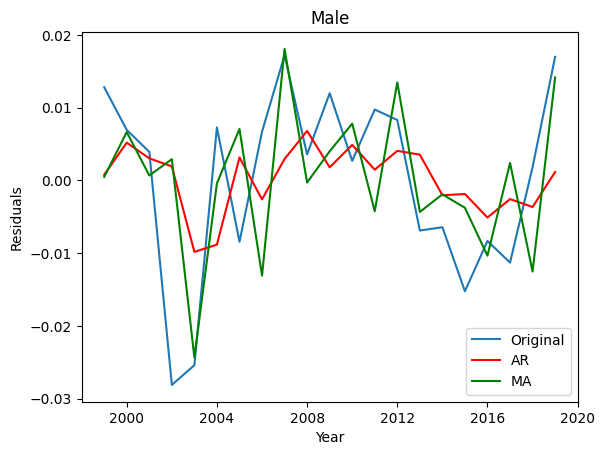

In [ ]:
model = ARIMA(male_residual, order=(1, 0, 0), freq=male_residual.index.inferred_freq)
results_AR = model.fit()
model2 = ARIMA(male_residual, order=(0, 0, 1), freq=male_residual.index.inferred_freq)
results_MA = model2.fit()
plt.plot(male_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Male')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  63.657
Date:                Fri, 03 May 2024   AIC                           -121.315
Time:                        22:23:02   BIC                           -118.181
Sample:                    01-01-1999   HQIC                          -120.634
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.005      0.166      0.868      -0.008       0.010
ar.L1          0.3668      0.220      1.668      0.095      -0.064       0.798
sigma2         0.0001   4.83e-05      2.802      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  64.376
Date:                Fri, 03 May 2024   AIC                           -122.751
Time:                        22:23:02   BIC                           -119.618
Sample:                    01-01-1999   HQIC                          -122.071
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.005      0.090      0.928      -0.010       0.011
ma.L1          0.9995     59.701      0.017      0.987    -116.012     118.011
sigma2         0.0001      0.007      0.017      0.9

## Race

### Black (Non-Hispanic)


In [ ]:
black_df = heart_df[heart_df['race']== 'Black (Non-Hispanic)']

In [ ]:
avg_black_df = black_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_black_df['avg_rate_disease'] = avg_black_df['rate_disease']
avg_black_df = avg_black_df.drop(columns=['rate_disease'])

Text(0.5, 1.0, 'Black (Non-Hispanic)')

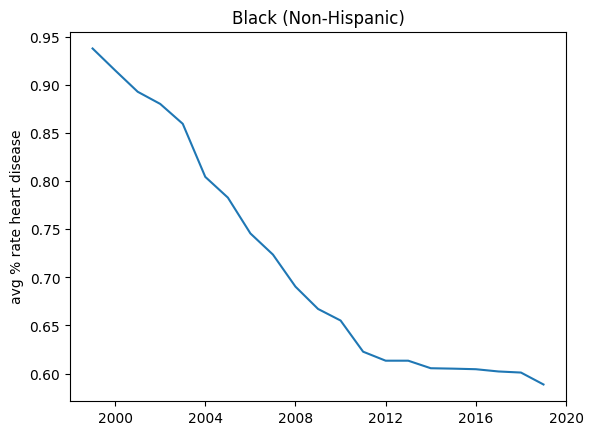

In [ ]:
plt.plot(pd.to_datetime(avg_black_df['year'], format="%Y"), avg_black_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Black (Non-Hispanic)')

In [ ]:
# get x and y vectors
x = avg_black_df['year']
y = avg_black_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.9914902652992912}

Text(0.5, 1.0, 'Black (Non-Hispanic)')

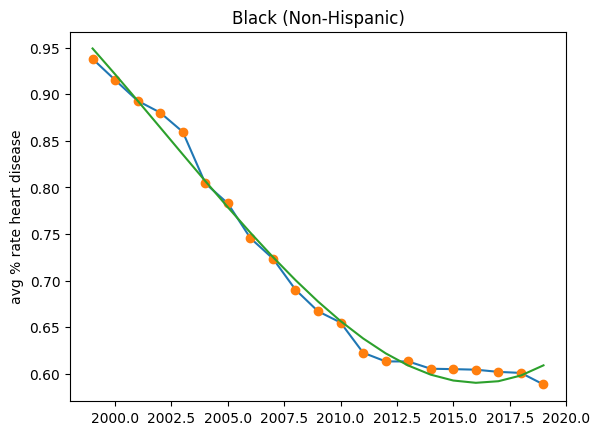

In [ ]:
plt.plot(avg_black_df['year'], avg_black_df['avg_rate_disease'])
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('Black (Non-Hispanic)')

In [ ]:
avg_black_df['residual'] = y_new - avg_black_df['avg_rate_disease']

In [ ]:
avg_black_df.head()

,year,avg_rate_disease,residual
0,1999,0.937852,0.011139
1,2000,0.915144,0.006181
2,2001,0.892887,0.000087
3,2002,0.880229,-0.015992
4,2003,0.859576,-0.024160


Text(0.5, 1.0, 'Black (Non-Hispanic)')

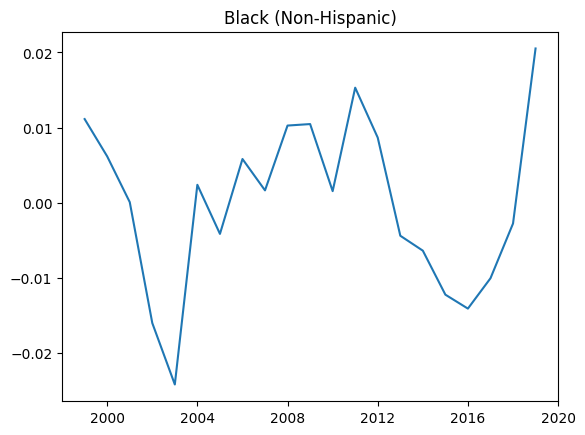

In [ ]:
plt.plot(pd.to_datetime(avg_black_df['year'],format="%Y"), avg_black_df['residual'])
plt.title("Black (Non-Hispanic)")

In [ ]:
black_residual = avg_black_df[['year','residual']].set_index('year')
black_residual.index = pd.to_datetime(black_residual.index,format='%Y')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


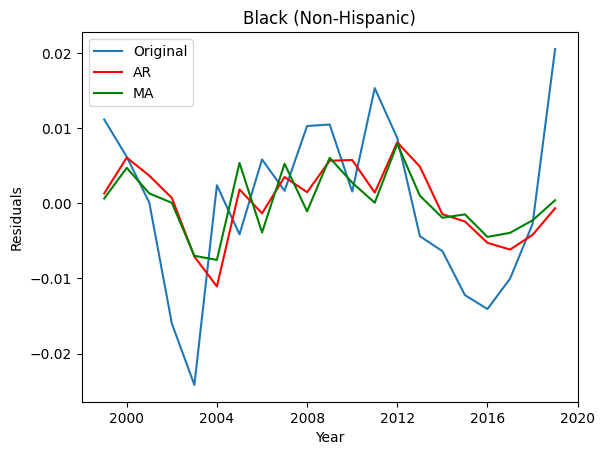

In [ ]:
model = ARIMA(black_residual, order=(1, 0, 0), freq=black_residual.index.inferred_freq)
results_AR = model.fit()

model2 = ARIMA(black_residual, order=(0, 0, 1), freq=black_residual.index.inferred_freq)
results_MA = model2.fit()

plt.plot(black_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Black (Non-Hispanic)')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  67.344
Date:                Fri, 03 May 2024   AIC                           -128.688
Time:                        22:23:05   BIC                           -125.554
Sample:                    01-01-1999   HQIC                          -128.008
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.005      0.260      0.795      -0.008       0.011
ar.L1          0.4855      0.235      2.064      0.039       0.024       0.947
sigma2      9.466e-05   3.43e-05      2.759      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  67.176
Date:                Fri, 03 May 2024   AIC                           -128.353
Time:                        22:23:05   BIC                           -125.219
Sample:                    01-01-1999   HQIC                          -127.673
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.004      0.175      0.861      -0.006       0.008
ma.L1          0.4761      0.283      1.683      0.092      -0.078       1.031
sigma2      9.622e-05   4.02e-05      2.391      0.0

### Hispanic

In [ ]:
hispanic_df = heart_df[heart_df['race']== 'Hispanic']

In [ ]:
avg_hispanic_df = hispanic_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_hispanic_df['avg_rate_disease'] = avg_hispanic_df['rate_disease']
avg_hispanic_df = avg_hispanic_df.drop(columns=['rate_disease'])

Text(0.5, 1.0, 'Hispanic')

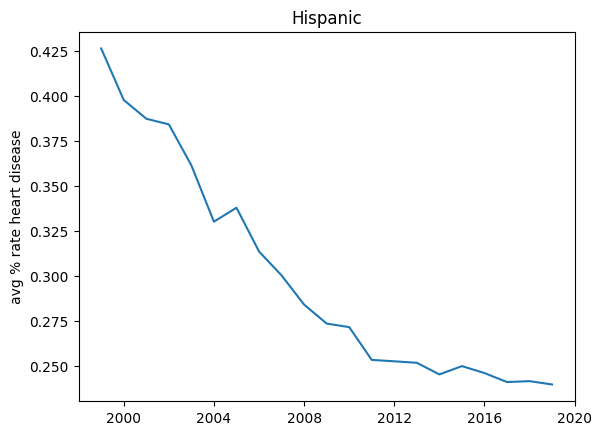

In [ ]:
plt.plot(pd.to_datetime(avg_hispanic_df['year'], format="%Y"), avg_hispanic_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Hispanic')

In [ ]:
# get x and y vectors
x = avg_hispanic_df['year']
y = avg_hispanic_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.9897269500052439}

Text(0.5, 1.0, 'Hispanic')

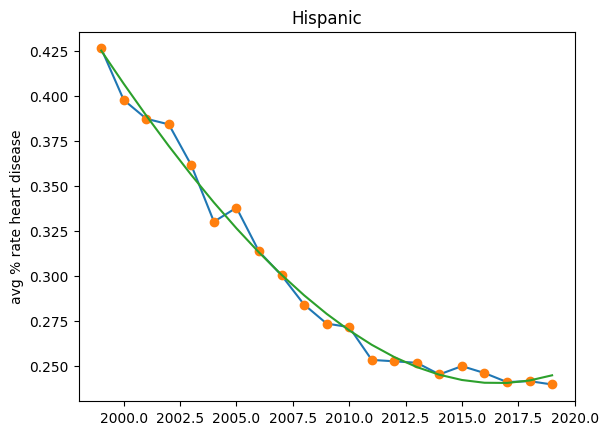

In [ ]:
plt.plot(avg_hispanic_df['year'], avg_hispanic_df['avg_rate_disease'])
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('Hispanic')

In [ ]:
avg_hispanic_df['residual'] = y_new - avg_hispanic_df['avg_rate_disease']

In [ ]:
avg_hispanic_df.head()

,year,avg_rate_disease,residual
0,1999,0.426459,-0.001191
1,2000,0.397859,0.009001
2,2001,0.387438,0.001738
3,2002,0.384302,-0.012040
4,2003,0.361546,-0.005386


Text(0.5, 1.0, 'Hispanic')

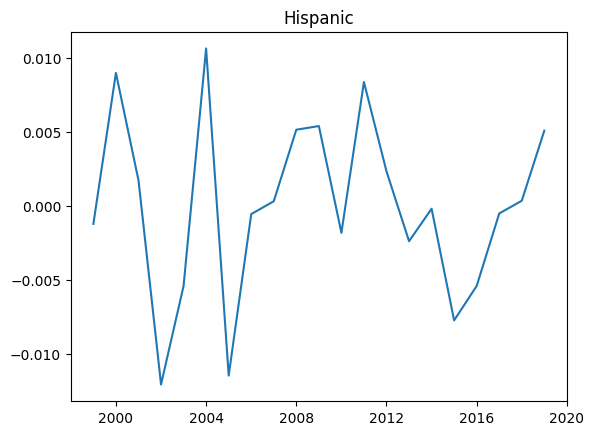

In [ ]:
plt.plot(pd.to_datetime(avg_hispanic_df['year'],format="%Y"), avg_hispanic_df['residual'])
plt.title("Hispanic")

In [ ]:
hispanic_residual = avg_hispanic_df[['year','residual']].set_index('year')
hispanic_residual.index = pd.to_datetime(hispanic_residual.index,format='%Y')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


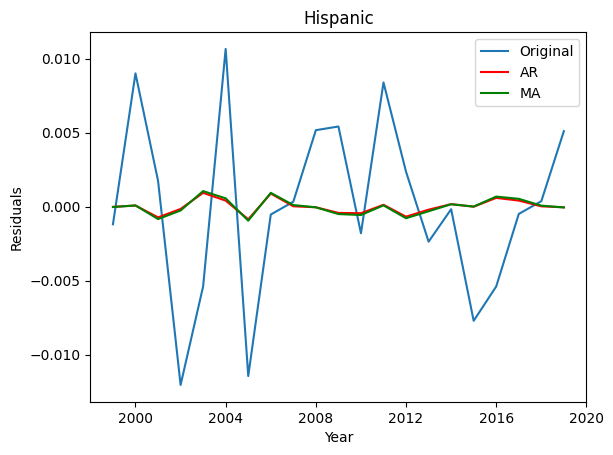

In [ ]:
model = ARIMA(hispanic_residual, order=(1, 0, 0), freq=hispanic_residual.index.inferred_freq)
results_AR = model.fit()

model2 = ARIMA(hispanic_residual, order=(0, 0, 1), freq=hispanic_residual.index.inferred_freq)
results_MA = model2.fit()

plt.plot(hispanic_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Hispanic')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  77.646
Date:                Fri, 03 May 2024   AIC                           -149.293
Time:                        22:23:08   BIC                           -146.159
Sample:                    01-01-1999   HQIC                          -148.613
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.55e-05      0.001     -0.013      0.990      -0.002       0.002
ar.L1         -0.0788      0.262     -0.301      0.763      -0.592       0.434
sigma2      3.593e-05   1.64e-05      2.193      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  77.682
Date:                Fri, 03 May 2024   AIC                           -149.363
Time:                        22:23:08   BIC                           -146.229
Sample:                    01-01-1999   HQIC                          -148.683
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.526e-05      0.001     -0.021      0.983      -0.002       0.002
ma.L1         -0.0912      0.268     -0.341      0.733      -0.616       0.433
sigma2      3.578e-05   1.71e-05      2.089      0.0

## American Indian/Alaska Native

In [ ]:
aian_df = heart_df[heart_df['race']== 'American Indian/Alaska Native']

In [ ]:
avg_aian_df = aian_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_aian_df['avg_rate_disease'] = avg_aian_df['rate_disease']
avg_aian_df = avg_aian_df.drop(columns=['rate_disease'])

Text(0.5, 1.0, 'American Indian/Alaska Native')

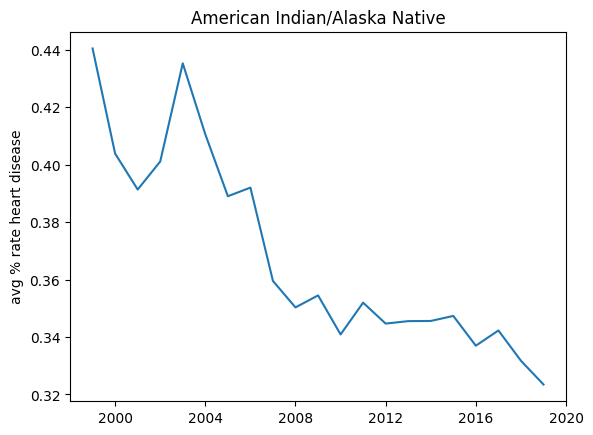

In [ ]:
plt.plot(pd.to_datetime(avg_aian_df['year'], format="%Y"), avg_aian_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('American Indian/Alaska Native')

In [ ]:
# get x and y vectors
x = avg_aian_df['year']
y = avg_aian_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.8411925102852928}

Text(0.5, 1.0, 'American Indian/Alaska Native')

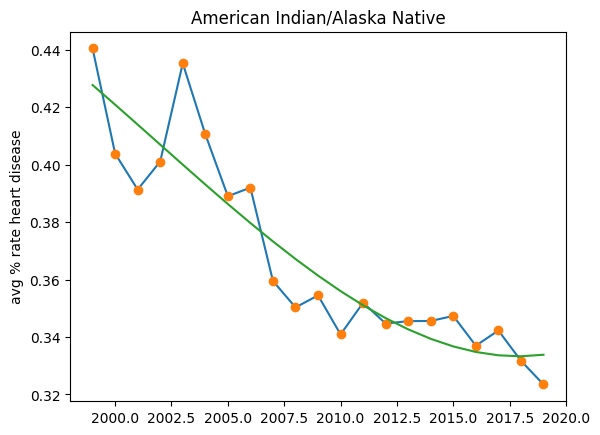

In [ ]:
plt.plot(avg_aian_df['year'], avg_aian_df['avg_rate_disease'])
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('American Indian/Alaska Native')

In [ ]:
avg_aian_df['residual'] = y_new - avg_aian_df['avg_rate_disease']

In [ ]:
avg_aian_df.head()

,year,avg_rate_disease,residual
0,1999,0.440449,-0.012719
1,2000,0.403867,0.017029
2,2001,0.391338,0.022624
3,2002,0.401098,0.005883
4,2003,0.435278,-0.035270


Text(0.5, 1.0, 'American Indian/Alaska Native')

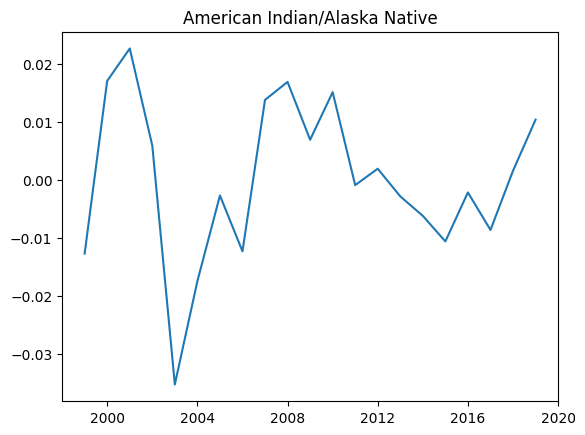

In [ ]:
plt.plot(pd.to_datetime(avg_aian_df['year'], format="%Y"), avg_aian_df['residual'])
plt.title("American Indian/Alaska Native")

In [ ]:
aian_residual = avg_aian_df[['year','residual']].set_index('year')
aian_residual.index = pd.to_datetime(aian_residual.index,format='%Y')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


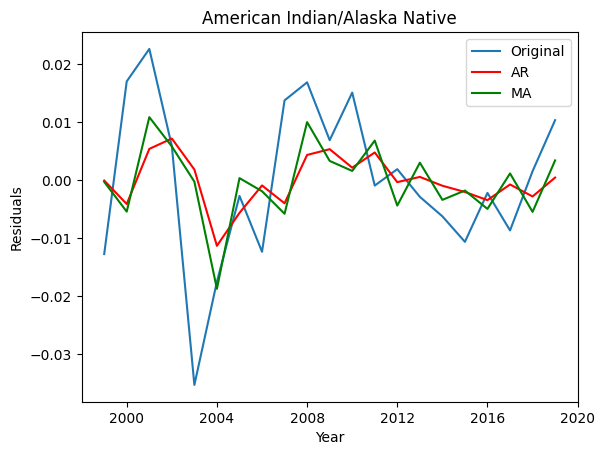

In [ ]:
model = ARIMA(aian_residual, order=(1, 0, 0), freq=aian_residual.index.inferred_freq)
results_AR = model.fit()

model2 = ARIMA(aian_residual, order=(0, 0, 1), freq=aian_residual.index.inferred_freq)
results_MA = model2.fit()

plt.plot(aian_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('American Indian/Alaska Native')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  61.749
Date:                Fri, 03 May 2024   AIC                           -117.498
Time:                        22:23:09   BIC                           -114.364
Sample:                    01-01-1999   HQIC                          -116.818
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.565e-05      0.004     -0.013      0.990      -0.009       0.008
ar.L1          0.3193      0.301      1.061      0.289      -0.270       0.909
sigma2         0.0002   4.63e-05      3.513      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  62.585
Date:                Fri, 03 May 2024   AIC                           -119.169
Time:                        22:23:09   BIC                           -116.036
Sample:                    01-01-1999   HQIC                          -118.489
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.004     -0.064      0.949      -0.009       0.008
ma.L1          0.5269      0.373      1.414      0.157      -0.203       1.257
sigma2         0.0001    3.9e-05      3.806      0.0

### Asian/Pacific Islander

In [ ]:
aapi_df = heart_df[heart_df['race']== 'Asian/Pacific Islander']

In [ ]:
avg_aapi_df = aapi_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_aapi_df['avg_rate_disease'] = avg_aapi_df['rate_disease']
avg_aapi_df = avg_aapi_df.drop(columns=['rate_disease'])

Text(0.5, 1.0, 'Asian/Pacific Islander')

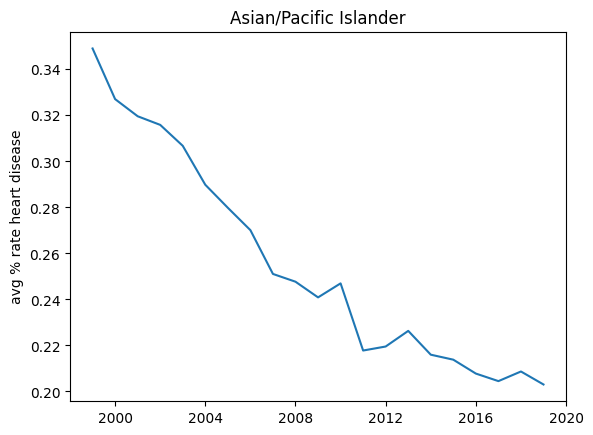

In [ ]:
plt.plot(pd.to_datetime(avg_aapi_df['year'], format="%Y"), avg_aapi_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Asian/Pacific Islander')

In [ ]:
# get x and y vectors
x = avg_aapi_df['year']
y = avg_aapi_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.985953247389329}

Text(0.5, 1.0, 'Asian/Pacific Islander')

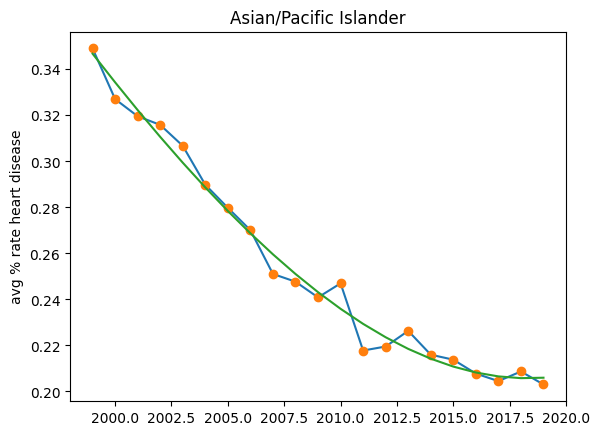

In [ ]:
plt.plot(avg_aapi_df['year'], avg_aapi_df['avg_rate_disease'])
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('Asian/Pacific Islander')

In [ ]:
avg_aapi_df['residual'] = y_new - avg_aapi_df['avg_rate_disease']

In [ ]:
avg_aapi_df.head()

,year,avg_rate_disease,residual
0,1999,0.349054,-0.002270
1,2000,0.327051,0.007297
2,2001,0.319593,0.002694
3,2002,0.315845,-0.005212
4,2003,0.306743,-0.007326


Text(0.5, 1.0, 'Asian/Pacific Islander')

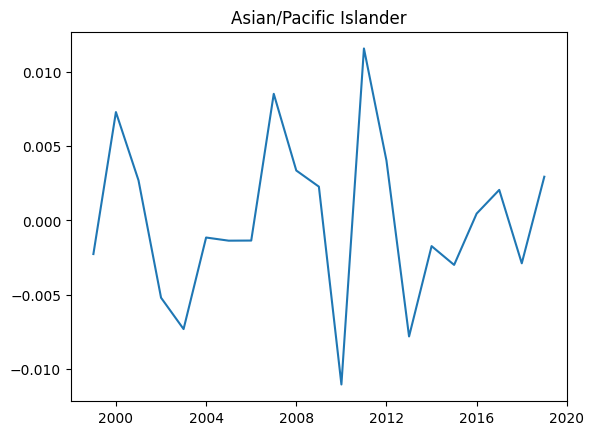

In [ ]:
plt.plot(pd.to_datetime(avg_aapi_df['year'],format="%Y"), avg_aapi_df['residual'])
plt.title("Asian/Pacific Islander")

In [ ]:
aapi_residual = avg_aapi_df[['year','residual']].set_index('year')
aapi_residual.index = pd.to_datetime(aapi_residual.index,format='%Y')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


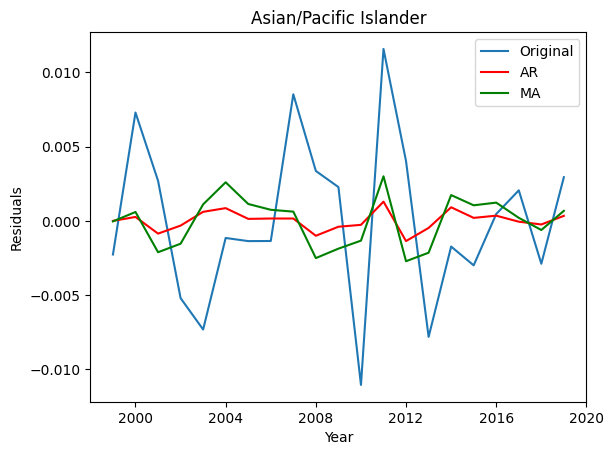

In [ ]:
model = ARIMA(aapi_residual, order=(1, 0, 0), freq=aapi_residual.index.inferred_freq)
results_AR = model.fit()
model2 = ARIMA(aapi_residual, order=(0, 0, 1), freq=aapi_residual.index.inferred_freq)
results_MA = model2.fit()
plt.plot(aapi_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Asian/Pacific Islander')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  80.061
Date:                Fri, 03 May 2024   AIC                           -154.123
Time:                        22:23:11   BIC                           -150.989
Sample:                    01-01-1999   HQIC                          -153.443
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.546e-06      0.001     -0.005      0.996      -0.002       0.002
ar.L1         -0.1174      0.226     -0.520      0.603      -0.560       0.325
sigma2      2.857e-05   1.25e-05      2.283      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  80.287
Date:                Fri, 03 May 2024   AIC                           -154.575
Time:                        22:23:11   BIC                           -151.441
Sample:                    01-01-1999   HQIC                          -153.895
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.004e-05      0.001     -0.049      0.961      -0.002       0.002
ma.L1         -0.3126      0.232     -1.347      0.178      -0.767       0.142
sigma2      2.778e-05   1.46e-05      1.898      0.0

## Geographic Region

### Southeast

Text(0.5, 1.0, 'Southeast')

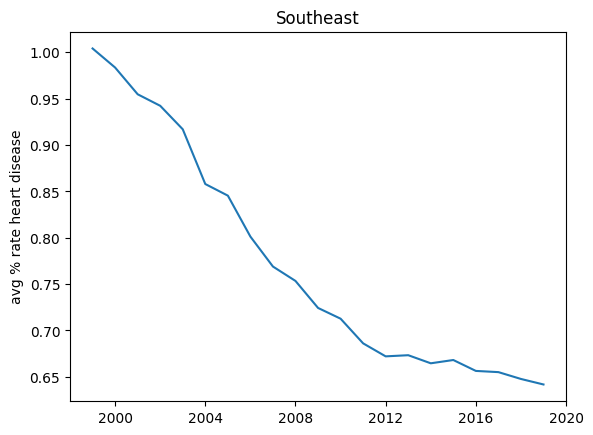

In [ ]:
southeast_df = heart_df[heart_df['region']== 'Southeast']
avg_southeast_df = southeast_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_southeast_df['avg_rate_disease'] = avg_southeast_df['rate_disease']
avg_southeast_df = avg_southeast_df.drop(columns=['rate_disease'])
plt.plot(pd.to_datetime(avg_southeast_df['year'], format="%Y"), avg_southeast_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Southeast')

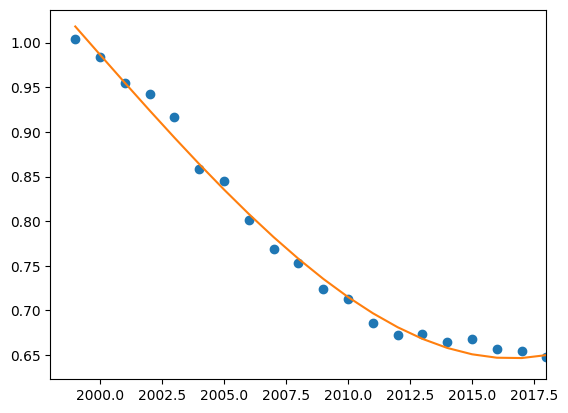

Text(0.5, 1.0, 'Southeast')

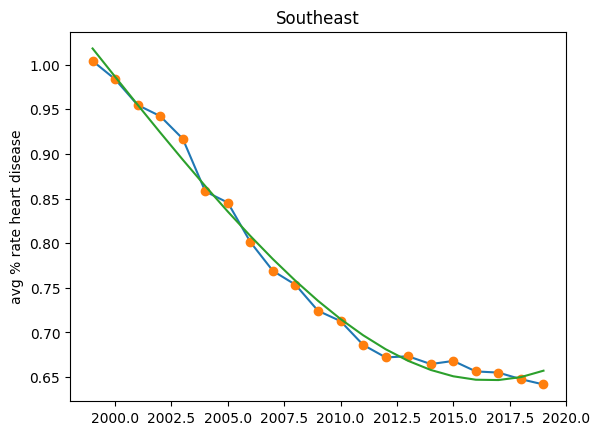

In [ ]:
# get x and y vectors
x = avg_southeast_df['year']
y = avg_southeast_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)

plt.plot(x, y)
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('Southeast')
plt.show()

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.9917562597952132}

In [ ]:
avg_southeast_df['residual'] = y_new - avg_southeast_df['avg_rate_disease']
avg_southeast_df.head()

,year,avg_rate_disease,residual
0,1999,1.004152,0.013925
1,2000,0.983598,0.002823
2,2001,0.954747,0.000230
3,2002,0.942323,-0.018376
4,2003,0.916997,-0.023463


Text(0.5, 1.0, 'Southeast')

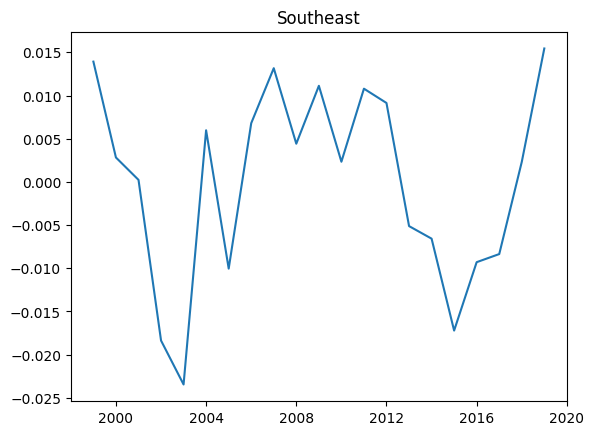

In [ ]:
plt.plot(pd.to_datetime(avg_southeast_df['year'],format="%Y"), avg_southeast_df['residual'])
plt.title("Southeast")

In [ ]:
se_residual = avg_southeast_df[['year','residual']].set_index('year')
se_residual.index = pd.to_datetime(se_residual.index,format='%Y')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


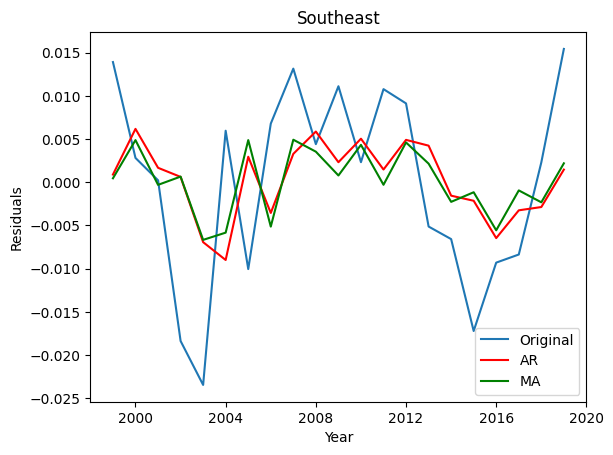

In [ ]:
model = ARIMA(se_residual, order=(1, 0, 0), freq=se_residual.index.inferred_freq)
results_AR = model.fit()

model2 = ARIMA(se_residual, order=(0, 0, 1), freq=se_residual.index.inferred_freq)
results_MA = model2.fit()

plt.plot(se_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Southeast')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  66.450
Date:                Fri, 03 May 2024   AIC                           -126.900
Time:                        12:48:43   BIC                           -123.767
Sample:                    01-01-1999   HQIC                          -126.220
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.004      0.220      0.826      -0.007       0.009
ar.L1          0.4061      0.212      1.912      0.056      -0.010       0.822
sigma2         0.0001    4.8e-05      2.157      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  66.202
Date:                Fri, 03 May 2024   AIC                           -126.403
Time:                        12:48:43   BIC                           -123.270
Sample:                    01-01-1999   HQIC                          -125.723
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.141      0.888      -0.006       0.007
ma.L1          0.3747      0.199      1.885      0.059      -0.015       0.764
sigma2         0.0001   5.13e-05      2.069      0.0

### Southwest

Text(0.5, 1.0, 'Southwest')

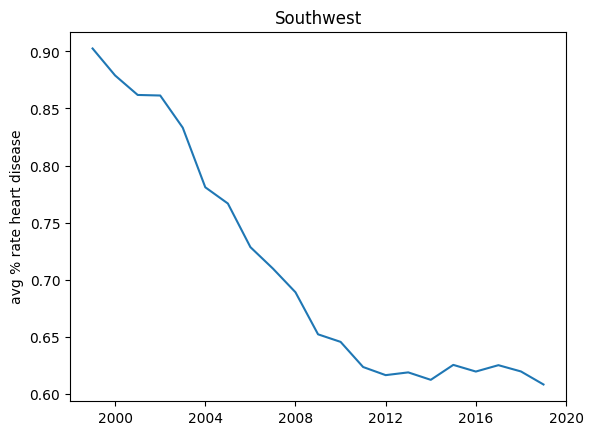

In [ ]:
southwest_df = heart_df[heart_df['region']== 'Southwest']
avg_southwest_df = southwest_df.groupby('year').agg({'rate_disease':'mean'}).reset_index()
avg_southwest_df['avg_rate_disease'] = avg_southwest_df['rate_disease']
avg_southwest_df = avg_southwest_df.drop(columns=['rate_disease'])
plt.plot(pd.to_datetime(avg_southwest_df['year'], format="%Y"), avg_southwest_df['avg_rate_disease'])
plt.ylabel('avg % rate heart disease')
plt.title('Southwest')


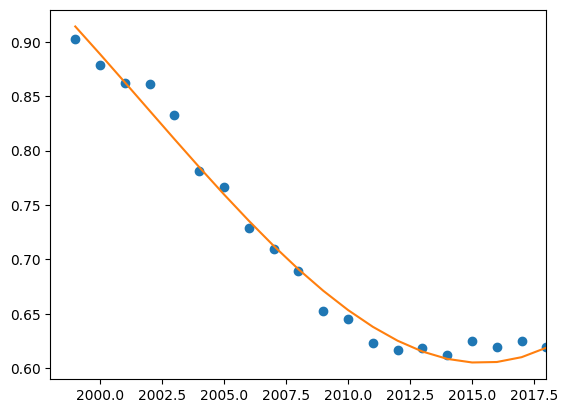

Text(0.5, 1.0, 'Southwest')

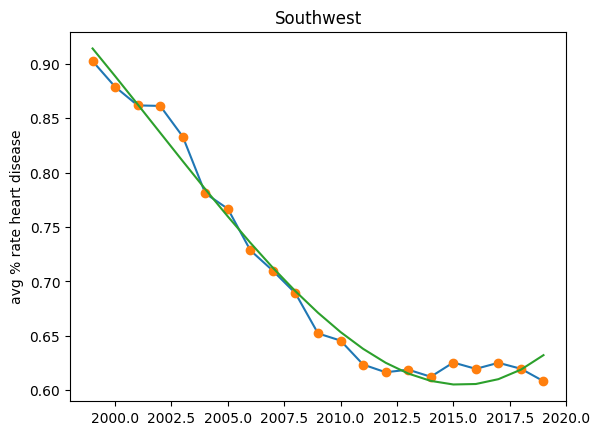

In [ ]:
# get x and y vectors
x = avg_southwest_df['year']
y = avg_southwest_df['avg_rate_disease']

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(1999, 2019, 21)
y_new = f(x_new)


plt.plot(x, y)
plt.plot(x,y,'o', x_new, y_new)
plt.ylabel('avg % rate heart disease')
plt.title('Southwest')
plt.show()

In [ ]:
polyfit_r2(x,y,3)

{'r_squared': 0.9834451938100801}

Text(0.5, 1.0, 'Southwest')

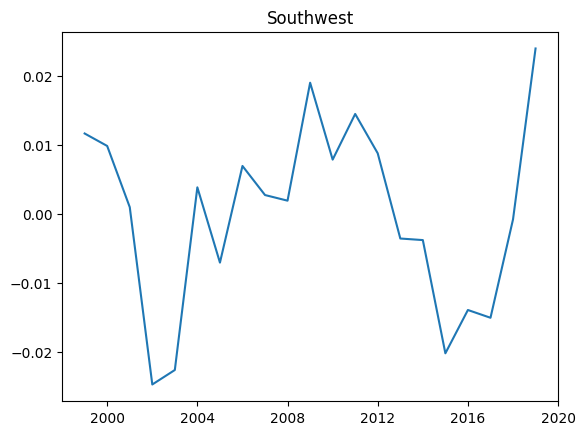

In [ ]:
avg_southwest_df['residual'] = y_new - avg_southwest_df['avg_rate_disease']
avg_southwest_df.head()
plt.plot(pd.to_datetime(avg_southwest_df['year'],format="%Y"), avg_southwest_df['residual'])
plt.title("Southwest")

In [ ]:
sw_residual = avg_southwest_df[['year','residual']].set_index('year')
sw_residual.index = pd.to_datetime(sw_residual.index,format='%Y')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


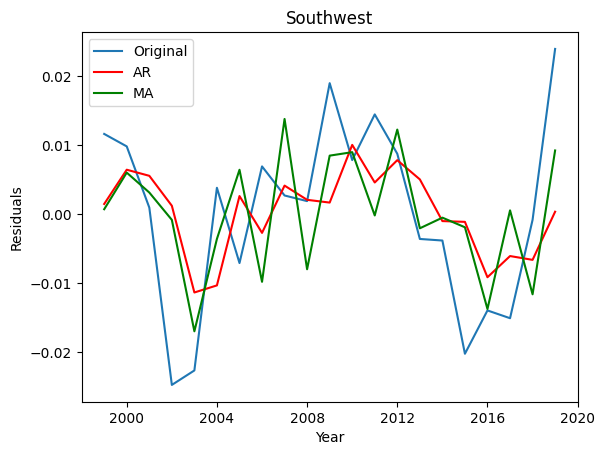

In [ ]:
model = ARIMA(sw_residual, order=(1, 0, 0), freq=sw_residual.index.inferred_freq)
results_AR = model.fit()

model2 = ARIMA(sw_residual, order=(0, 0, 1), freq=sw_residual.index.inferred_freq)
results_MA = model2.fit()

plt.plot(sw_residual, label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR')
plt.plot(results_MA.fittedvalues, color='green', label='MA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Southwest')
plt.show()

In [ ]:
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  63.605
Date:                Fri, 03 May 2024   AIC                           -121.211
Time:                        12:48:45   BIC                           -118.077
Sample:                    01-01-1999   HQIC                          -120.531
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.006      0.269      0.788      -0.009       0.012
ar.L1          0.4891      0.292      1.675      0.094      -0.083       1.061
sigma2         0.0001    4.4e-05      3.075      0.0

In [ ]:
print(results_MA.summary())

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  64.001
Date:                Fri, 03 May 2024   AIC                           -122.002
Time:                        12:48:45   BIC                           -118.868
Sample:                    01-01-1999   HQIC                          -121.322
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.005      0.155      0.877      -0.008       0.010
ma.L1          0.7889      0.163      4.848      0.000       0.470       1.108
sigma2         0.0001   5.52e-05      2.278      0.0